## Shape recognition 

In [1]:
import numpy as np
import json
import pickle


## Load training data

In [2]:
seq_length=100
img_size=20


def normalize_points(lpoints):
    p=np.array(lpoints)
    p=p-p.min(axis=0)
    return p/(p.max()+0.01)

def iter_training():
    for line in open("whiteboard/data/training.json"):
        obj=json.loads(line.strip())
        yield obj["shape"],obj["points"]

def iter_normalized():
    for shape,points in iter_training():
        if shape!="?" and len(points)>20:
            yield shape,normalize_points(points)

def iter_sequences(size):
    for shape,points in iter_normalized():
        seq=np.array(lpoints[:size])
        if len(lpoints)<size:
            seq=np.pad(seq,pad_width=( (0,size-len(lpoints)) , (0,0) ), mode="edge")
        yield shape,seq

hsymetry={"rectangle":"rectangle","elispse":"elispse",
          "leftbracket":"leftbracket","rightbracket":"rightbracket",
          "sigma":"sigma","leftarrow":"leftarrow","rightarrow":"rightarrow",
          "uparrow":"downarrow","downarrow":"uparrow",
          "hline":"hline","vline":"vline","upline":"downline","downline":"upline"}


vsymetry={"rectangle":"rectangle","elispse":"elispse","triangle":"triangle",
          "leftbracket":"rightbracket","rightbracket":"leftbracket",
          "leftarrow":"rightarrow","rightarrow":"leftarrow",
          "uparrow":"uparrow","downarrow":"downarrow",
          "hline":"hline","vline":"vline","upline":"downline","downline":"upline"}



def enrich_image(shape,img):
    yield shape,img
    
    #horizontal symetry
    if shape in hsymetry:
        yield hsymetry[shape],np.flipud(img)

    #vertical symetry
    if shape in vsymetry:
        yield vsymetry[shape],np.fliplr(img)

def iter_images():
    for shape,points in iter_normalized():
        img=np.zeros((img_size,img_size))
        for y,x in np.rollaxis(points, 0):
            img[int(x*img_size),int(y*img_size)]=1.0
        for shape1,img1 in enrich_image(shape,img):
            yield shape1,img1.reshape(img_size,img_size,1)


In [13]:
def point_sampling(seq,size):
    ratio=float(len(seq)-1)/(size-1)
    for i in range(size):
        position=int(np.trunc(i*ratio))
        residual=i*ratio-position
        if position<len(seq)-1:
            x0,y0=seq[position]
            x1,y1=seq[position+1]
            x=int(x0+(x1-x0)*residual)
            y=int(y0+(y1-y0)*residual)
            yield (x,y)
        else:
            yield seq[-1]


In [14]:
for p in point_sampling([(0,0),(10,10),(300,200),(200,100),(50,50),(70,70)],13):
    print(p)

(0, 0)
(4, 4)
(8, 8)
(82, 57)
(203, 136)
(291, 191)
(250, 150)
(208, 108)
(149, 83)
(87, 62)
(53, 53)
(61, 61)
(70, 70)


In [20]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,Flatten,MaxPool2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [16]:
X=np.array([p for _,p in iter_images() ])
X.shape

(2432, 20, 20, 1)

In [17]:
yLabel=[label for label,_ in iter_images() ]
labelEncoder=LabelEncoder().fit(yLabel)
num_classes=len(labelEncoder.classes_)
y=to_categorical(labelEncoder.transform(yLabel))
y.shape

(2432, 15)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [31]:
model=Sequential()
model.add(Conv2D(32, kernel_size=(4,4),activation='relu',input_shape=(img_size,img_size,1)))
#model.add(Conv2D(16, kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(1,1), padding='valid'))
model.add(Flatten())
model.add(Dropout(0.2)) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 17, 17, 32)        544       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 15)               

In [32]:
model.compile(loss=CategoricalCrossentropy(label_smoothing=0.3),
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=10, epochs=20,verbose=1, validation_data=(X_test,y_test))
score = model.evaluate(X_test,y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
195/195 [==============================] - 2s 10ms/step - loss: 1.9692 - accuracy: 0.6787 - val_loss: 1.6902 - val_accuracy: 0.8439
Epoch 2/20
195/195 [==============================] - 2s 10ms/step - loss: 1.5976 - accuracy: 0.9290 - val_loss: 1.5625 - val_accuracy: 0.9097
Epoch 3/20
195/195 [==============================] - 2s 10ms/step - loss: 1.5085 - accuracy: 0.9681 - val_loss: 1.5231 - val_accuracy: 0.9528
Epoch 4/20
195/195 [==============================] - 2s 10ms/step - loss: 1.4680 - accuracy: 0.9877 - val_loss: 1.5118 - val_accuracy: 0.9466
Epoch 5/20
195/195 [==============================] - 2s 11ms/step - loss: 1.4451 - accuracy: 0.9943 - val_loss: 1.5106 - val_accuracy: 0.9466
Epoch 6/20
195/195 [==============================] - 2s 10ms/step - loss: 1.4343 - accuracy: 0.9974 - val_loss: 1.5064 - val_accuracy: 0.9425
Epoch 7/20
195/195 [==============================] - 3s 15ms/step - loss: 1.4241 - accuracy: 0.9974 - val_loss: 1.4821 - val_accuracy: 0.9569

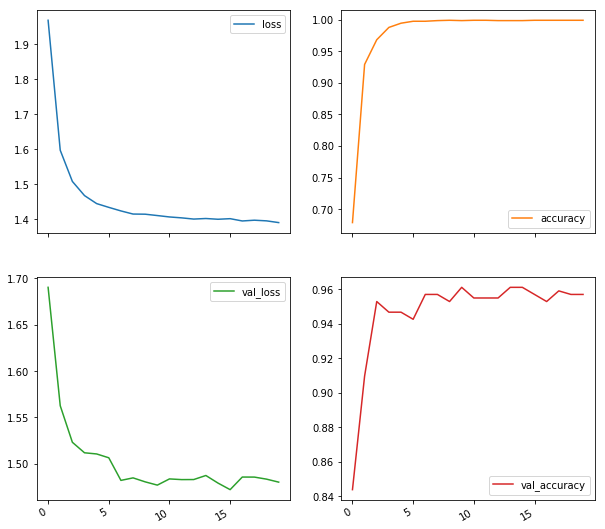

In [35]:
import pandas as pd
df=pd.DataFrame(history.history)
_=df.plot(kind="line",subplots=(2,2),figsize=(10,10),layout=(2,2))

In [36]:
modelDir="whiteboard/model"
model.save(modelDir)

pickle.dump(labelEncoder,open(modelDir+"/assets/labelEncoder.pickle","wb"))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: whiteboard/model/assets


In [37]:
import matplotlib.pyplot as plt

%matplotlib inline

In [38]:
predictions=model.predict(X)
predictedLabels=labelEncoder.inverse_transform(predictions.argmax(axis=1))

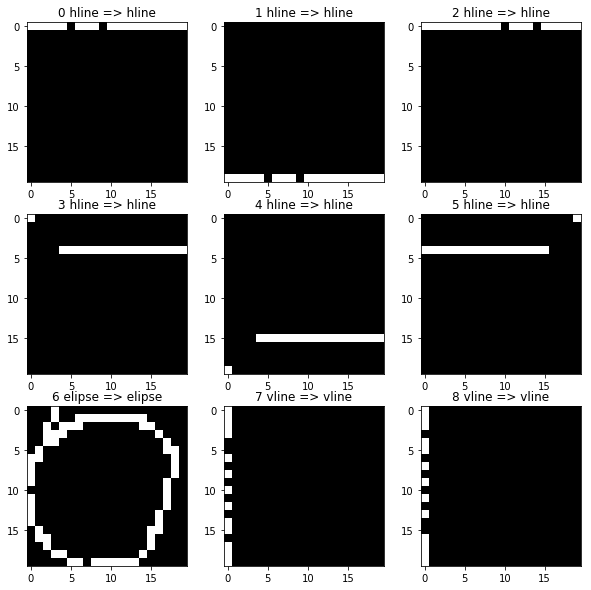

In [39]:
def show_plot(indices):
    plt.figure(figsize=(10,10))
    for p,i in enumerate(indices[:9]):
        plt.subplot(3,3,p+1)
        plt.imshow(X[i].reshape(img_size,img_size), cmap='gray', interpolation='none')
        plt.title("{} {} => {}".format(i,yLabel[i],predictedLabels[i]))

show_plot(range(9))

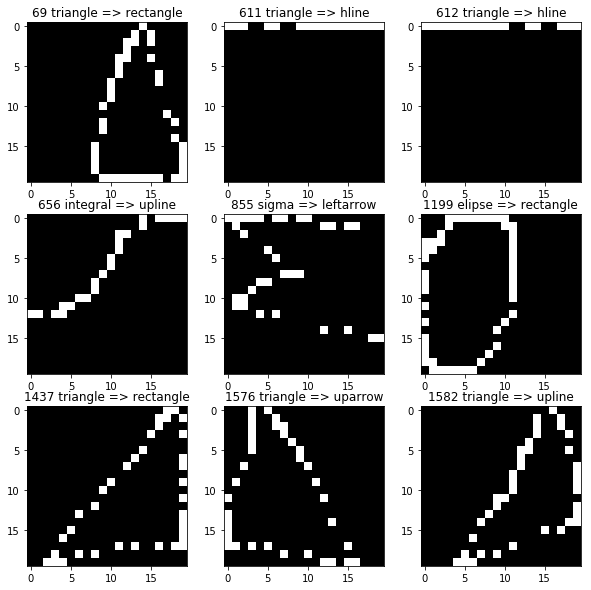

In [40]:
indices=[i for i,good in enumerate(predictedLabels==yLabel) if not good]
show_plot(indices)

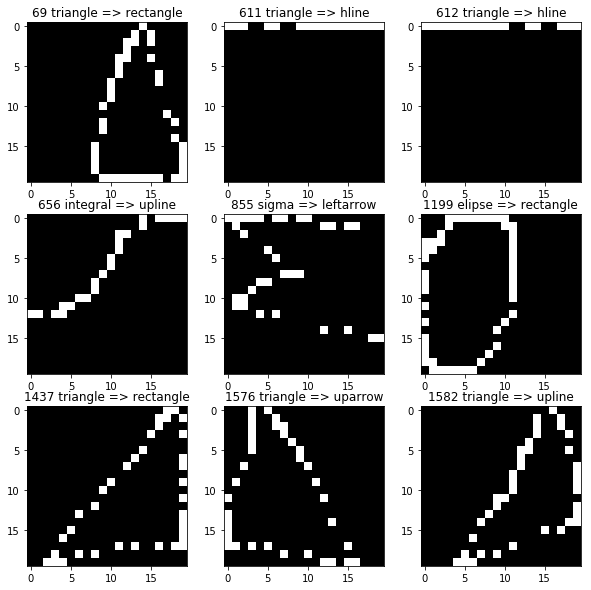

In [41]:
indices=[i for i,good in enumerate(predictedLabels==yLabel) if not good]
show_plot(indices)

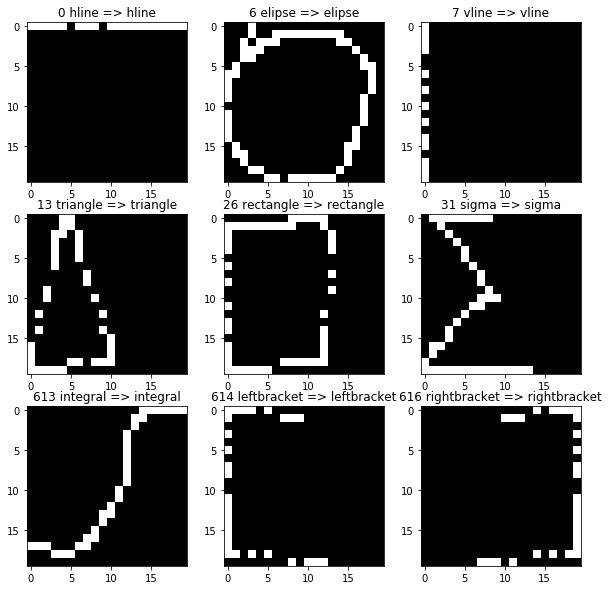

In [42]:
indices=[]
foundclasses=set(predictedLabels)
for i,c in enumerate(predictedLabels):
    if c in foundclasses:
        indices.append(i)
        foundclasses.remove(c)

show_plot(indices)

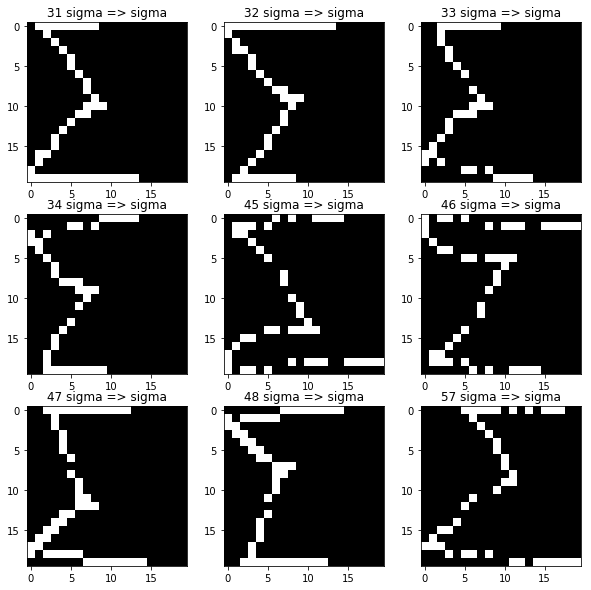

In [43]:
indices=[i for i,good in enumerate(predictedLabels=="sigma") if good]
show_plot(indices)

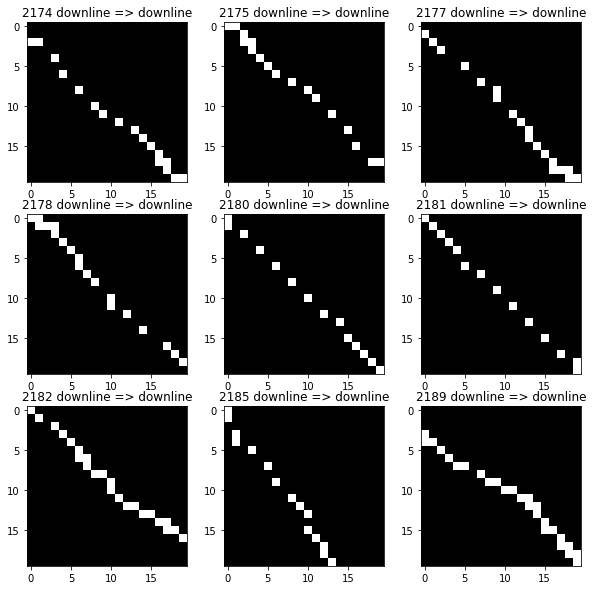

In [44]:
indices=[i for i,label in enumerate(yLabel) if label=="downline"]
show_plot(indices)

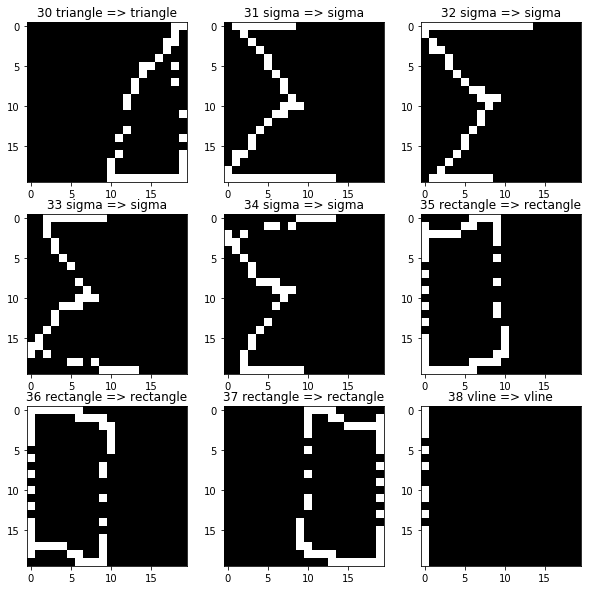

In [45]:
start=30
indices=range(start,start+9)
show_plot(indices)